In [ ]:
Note, this code is mo

This notebook provides a simple example of how a new user can leverage the MOSAIKS system to generate predictions of any new outcome. There are three steps: 

1) Merge labels (i.e. "ground truth") with corresponding MOSAIKS features, based on location

2) Train the prediction model using ridge regression and k-fold cross-validation

3) Show performance on the validation set of labeled data 

This example predicts population density throughout the United States, using labeled data from the Gridded Population of the World. It is designed to allow the user to easily replace this task with a new set of labeled data for a new outcome of interest.

# Step 1: Load data, and merge with satellite-based features using on location

### Import necessary packages

In [2]:
# Import necessary packages: These include custom MOSAIKS packages contained within the repo, as well as standard Python packages.
%load_ext autoreload
%autoreload 2
%matplotlib inline
from mosaiks import config as c
from mosaiks.utils.imports import *

env variable MOSAIKS_HOME not defined; setting to: "/home/ubuntu/cs230/mosaiks-paper"
If not desired, please reset os.environ["MOSAIKS_NAME"]


### Task-specific settings

Here, the user will need to adjust settings for their particular context. To run the population prediction, nothing should need to be updated. We call most task-specific settings from the config.py file contained within the repository. However, the user could choose to hard code any of these options, as desired, or add to the config.py file as needed.

In [17]:
# Name of your task
app = "housing"
c_app = getattr(c, app)
outcome_name = c_app["variable"]

# Chose the features that we'd like to use (if available, other features besides MOSAIKS features could be indicated here)
feattype = "random"

# Obtain the file paths you need for your application and feature type
# (this simply calls the filepaths listed in config.py for location of labeled and feature datasets)
c = io.get_filepaths(c, app, feattype)
c_app = getattr(c, app)

# Choose the sampling scheme for the grid (options: UAR (uniform-at-random) or POP (population-weighted))
sampling_type = c_app["sampling"]

# Choose whether to log the outcome variable or not for training and prediction
# (we log outcome variables with approximately log-normal distributions in the labeled data)
logs = c_app["logged"]

# These bounds are used to clip predictions at the observed minimum and maximum of the outcome
# variable in the labeled data
if logs == False:
    bounds = np.array([c_app["us_bounds_pred"]])
else:
    bounds = np.array([c_app["us_bounds_log_pred"]])

# Inputs needed to train model using ridge regression
solver_kwargs = {
    # set of possible hyperparameters to search over in cross-validation
    "lambdas": c_app["lambdas"],
    # do you want to return the predictions from the model?
    "return_preds": True,
    # input the bounds used to clip predictions
    "clip_bounds": bounds,
    # do you want to use an SVD solve or standard linear regression? (NB: SVD is much slower)
    "svd_solve": False,
    # do you want to allow hyperparameters to be chosen even if they lead to warnings about matrix invertibility?
    "allow_linalg_warning_instances": False,
}

# Set solver: We use ridge regression to solve the linear regression model. Other options may be explored by future users.
solver = solve.ridge_regression

# For plotting:
%matplotlib inline
sns.set(style="whitegrid")

### Merge labeled data with features by location

To generalize MOSAIKS across many tasks, we create a standardized grid onto which we project both satellite images and labeled training data. This grid is described in detail in Supplementary Materials Section S.2.1. As described in the Supplementary Materials, satellite images are extracted over the area of each grid cell, and corresponding features are created from each grid cell's imagery. Labeled data are averaged (or summed) over each grid cell.

We sample from this standardized grid in two ways: uniform-at-random (UAR) and population-weighted (POP). We draw 100,000 samples in each case, and the model is trained and all predictions are performed on this random sample. For the task of predicting population density, the sampling strategy we use is UAR, although the user can change this option in the config.py file.

Here, we merge satellite image-based features ("X") with labeled data ("Y") based on the location of the grid cell. This provides us with a training dataset in which each grid cell has both an outcome ("Y") and a corresponding vector of MOSAIKS features ("X").

To predict a new variable not predicted in the paper, the user will need to calculate grid cell labels from "ground-truth" measurements. These labels can then be merged onto the features. We show examples of how one might calculate these labels in the analysis/label_creation/ section of this replication. 

#### Load random features

This loads our feature matrix `X` for either the POP or UAR sample

In [18]:
# Load random features
X, latlons = io.get_X_latlon(c, sampling_type)

#### Merge features to labeled data, split into train and test sets

This function loads labeled data `Y` and merges these outcomes to random features `X` based on lat-lon locations. For outcomes that are logged, this function also transforms the outcome variable from levels to logs. If users want to log new outcomes, that should be performed at this stage. This function further splits the data into train (80%) and test (20%) sets; here we load just the train set.

In [19]:
(
    X_train,
    _,
    Y_train,
    _,
    latlons_train,
    _,
) = parse.merge_dropna_transform_split_train_test(c, app, X, latlons)

Loading labels...
Merging labels and features...
Splitting training/test...


# Step 2: Train MOSAIKS model

We use ridge regression to train a model to predict each outcome variable (i.e. "task") using the same set of MOSAIKS features. 

Within the training/validation sample, we choose the penalization parameter in ridge regression using k-fold cross-validation (here we choose 5 folds). The input vector of penalization parameters (lambdas) are listed in the config.py file (and can be adjusted by the user if desired). In most results, we show performance on the training/validation sample, although the test sample is used just once to assess performance of the trained model for each task (see Supplementary Materials Section S.2.6). Test set and validation set performance are nearly identical for each of the tasks we considered (Table S2). 

In [20]:
print("Training model...")
kfold_results = solve.kfold_solve(
    X_train,
    Y_train,
    solve_function=solver,
    num_folds=c.ml_model["n_folds"],
    return_model=True,
    **solver_kwargs
)
print("")

Training model...
on fold (of 5): 1 linalg warning on lambda=0.001: we will discard this model upon model selection
linalg warning on lambda=0.005623413251903491: we will discard this model upon model selection
linalg warning on lambda=0.03162277660168379: we will discard this model upon model selection
2 linalg warning on lambda=0.001: we will discard this model upon model selection
linalg warning on lambda=0.005623413251903491: we will discard this model upon model selection
linalg warning on lambda=0.03162277660168379: we will discard this model upon model selection
3 linalg warning on lambda=0.001: we will discard this model upon model selection
linalg warning on lambda=0.005623413251903491: we will discard this model upon model selection
linalg warning on lambda=0.03162277660168379: we will discard this model upon model selection
4 linalg warning on lambda=0.001: we will discard this model upon model selection
linalg warning on lambda=0.005623413251903491: we will discard this mod

/home/ubuntu/cs230/mosaiks-paper/code/mosaiks/solve/solve_functions.py:364: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "y_true_test": np.array(kfold_y_test),
/home/ubuntu/cs230/mosaiks-paper/code/mosaiks/solve/solve_functions.py:365: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "y_true_train": np.array(kfold_y_train),


In [21]:
## Store the metrics and the predictions from the best performing model
best_lambda_idx, best_metrics, best_preds = ir.interpret_kfold_results(
    kfold_results, "r2_score", hps=[("lambdas", solver_kwargs["lambdas"])]
)

# Step 3: Show performance in validation set and test set

Here, we show how the MOSAIKS predictions compare to labeled data. We use the training/validation set to do so, using the regression weights from the best-performing model chosen in the cross-validation step above. 

First, we show a simple scatter plot of labeled data against predictions. Second, we show the spatial distribution of labels and predictions.

### Labeled data versus predictions

/home/ubuntu/anaconda3/envs/mosaiks-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ubuntu/anaconda3/envs/mosaiks-env/lib/python3.9/site-packages/seaborn/axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Plotting log_price_per_sqft...


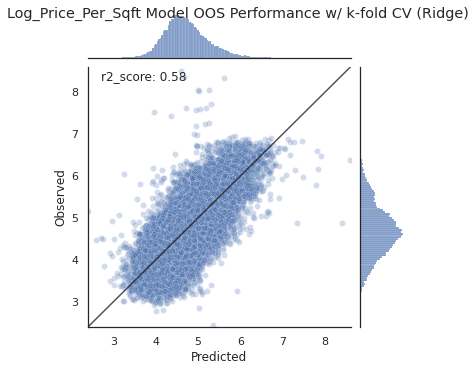

In [22]:
plots.performance_density(
    kfold_results,
    "Ridge",
    val=outcome_name,
    save_dir=None,
    app_name=app,
    kind="scatter",
    size=5
)

### Spatial distribution of observations and predictions

/home/ubuntu/cs230/mosaiks-paper/code/mosaiks/solve/interpret_results.py:86: UserWarning: The optimal hyperparameter is the lowest of the acceptable (i.e. no precision warnings) hyperparameters supplied. It is index 4 of the orignal hyperparamters passed in. For reference, 5 of 9 hyperparamters are considered acceptable; their indices  are [4 5 6 7 8].
  warnings.warn(


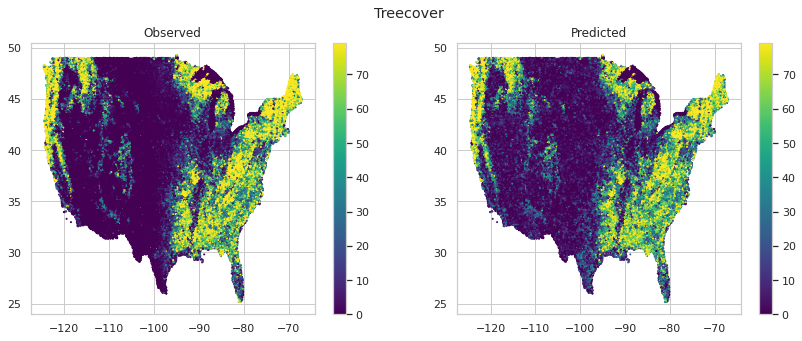

In [16]:
plots.spatial_scatter_obs_v_pred(
    kfold_results,
    latlons_train,
    model_info="Ridge",
    val=outcome_name,
    save_dir=None,
    app_name=app,
    s=1,
)